In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from EMAN2 import *

In [40]:
from __future__ import print_function
from skimage.transform import resize
from skimage.io import imsave
from skimage.segmentation import mark_boundaries
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from skimage.exposure import rescale_intensity
from tensorflow.keras.callbacks import History
from skimage import io
import matplotlib
import matplotlib.patches as mpatches
from skimage.measure import regionprops
from skimage.color import label2rgb
from skimage.morphology.selem import disk
import cv2
from skimage.filters import gaussian
from skimage.feature import peak_local_max, blob_log
#from scipy import ndimage
from skimage import morphology
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max


/var/folders/fn/nlgx_qdn2r19y90q6x372b3c0000gn/T/ipykernel_8498/3581288061.py:19: FutureWarning: The `skimage.morphology.selem` module is deprecated and will be removed in scikit-image 1.0 (`skimage.morphology.selem` has been moved to `skimage.morphology.footprints`).
  from skimage.morphology.selem import disk


In [79]:
label = EMData('membrane_slice128.hdf')
data = EMData('slice_128.hdf')
background = EMData('background_slice128.hdf')


In [4]:
b = a.numpy()

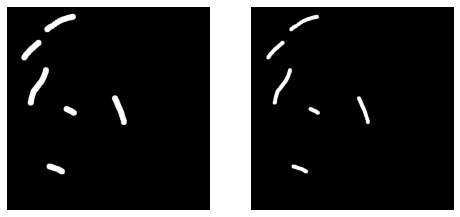

In [86]:
erosion = morphology.erosion(background.numpy(),disk(5))
plot_comparison(background.numpy(),erosion)

In [87]:
c = np.where(erosion>0)
c[0].shape

(15201,)

(0.0, 1000.0)

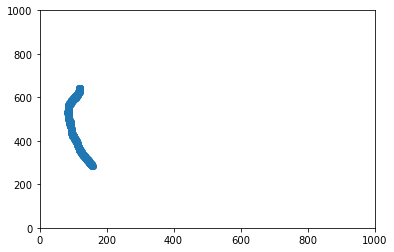

In [17]:
plt.scatter(c[1],c[0])
plt.xlim(0, 1000)
plt.ylim(0, 1000)

In [ ]:
a = label.get_clip(Region(119-2,642-2,5,5))
d = data.get_clip(Region(119-2,642-2,5,5))
#self.annotation=self.full_annotation.get_clip(Region(0,0,0,self.full_data["nx"],self.full_data["ny"],1))
plot_comparison(a.numpy(),d.numpy())

In [91]:
def create_training_set(data_f,label_f,bg_f,outfile,tile_sz=6,disk_sz=5):
    data = EMData(data_f)
    label = EMData(label_f)
    bg = EMData(bg_f)
    erosion = morphology.erosion(bg.numpy(),disk(5))
    
    coor = np.where(label.numpy()>0)    
    for i in range(15,len(coor[0])-15):
        x = int(coor[1][i])
        y = int(coor[0][i])
        d = data.get_clip(Region(x,y,tile_sz,tile_sz))
        l = label.get_clip(Region(x,y,tile_sz,tile_sz))
        d.write_image(outfile,-1)
        l.write_image(outfile,-1)
        
    coor_back = np.where(erosion>0)
    for i in range(100,15000,5):
        x = int(coor_back[1][i])
        y = int(coor_back[0][i])
        d = data.get_clip(Region(x,y,tile_sz,tile_sz))
        l = from_numpy(np.zeros((tile_sz,tile_sz)))
        d.write_image(outfile,-1)
        l.write_image(outfile,-1)

In [32]:
len(c[0])

1333

In [93]:
create_training_set('slice_128.hdf','membrane_slice128.hdf','background_slice128.hdf','membrane_trainset_withbg_6x6.hdf',6)

In [62]:
def load_particles(ptcls,labelshrink=1,ncopy=1, rng=None):
    if rng==None:
        rng=random
    #num=old_div(EMUtil.get_image_count(ptcls),2)
    #print(num)
    is3d=False
    e=EMData(ptcls,0, True)
    tsz=max(e["nx"],e["ny"])
    
    nframe=EMUtil.get_image_count(ptcls)
    if nframe==1:
        nframe=e["nz"]
        if nframe>1:
            is3d=True
    num = nframe//2
    data=[]
    label=[]
    ntrain=-1
    
    for i in range(num):
        for nc in range(ncopy):
            if is3d:
                ptl=EMData(ptcls,0, False,Region(0,0,i*2,tsz,tsz,1))
            else:
                ptl=EMData(ptcls,i*2, False, Region(0,0,tsz,tsz))
                           
            if ntrain<0 and ptl.get_attr_default("valid_set", 0)==1:
                ntrain=len(data)
            #ptl.process_inplace("threshold.belowtozero")
            if ncopy>1:
                tr=Transform()
                tr.set_rotation({"type":"2d","alpha":rng.random()*360.0})
                ptl.process_inplace("xform",{"transform":tr})
            ar=ptl.numpy().copy()
            #shp=np.shape(ar)
            data.append(ar)
            
            if is3d:
                ptl=EMData(ptcls,0, False,Region(0,0,i*2+1,tsz,tsz,1))
            else:
                ptl=EMData(ptcls,i*2+1, False, Region(0,0,tsz,tsz))
            #ptl.process_inplace("threshold.belowtozero")
                           
            if ncopy>1:
                ptl.process_inplace("xform",{"transform":tr})
            if labelshrink>1:
                ptl.process_inplace("math.meanshrink",{'n':int(labelshrink)})
            ar=ptl.numpy().copy()
            #shp=np.shape(ar)
            label.append(ar)

    if ntrain<0: ntrain=len(data)
    print("{:d} particles loaded, {:d} in training set, {:d} in validation set".format(len(data), ntrain, len(data)-ntrain))
    data=np.asarray(data,dtype=np.float32)
    
    print(data.shape)
    print("Std of particles: ",np.std(data))
    #data/=np.std(data.flatten())*3  #np.max(np.abs(data))
    data/=3. ### so the range is roughly (-1,1)
    label=np.asarray(label,dtype=np.float32)
    label/=(np.max(np.abs(label)))

    
    header=EMData(ptcls,0,True)
    shape=[header["nx"],header["ny"],header["nz"]]
    return data, label, shape, ntrain

4283 particles loaded, 4283 in training set, 0 in validation set
(4283, 6, 6)
Std of particles:  1.3932803


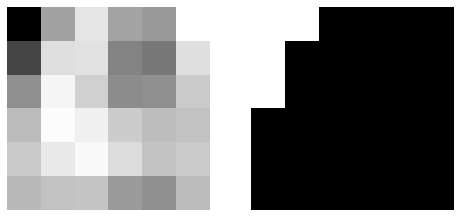

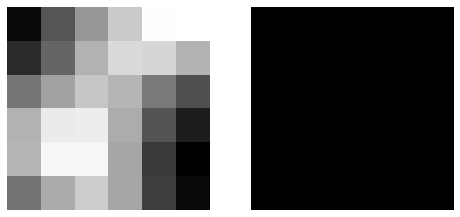

In [94]:
#load train data
datas, labels, shape, ntrain=load_particles('membrane_trainset_withbg_6x6.hdf',1,ncopy=1)
datas=normalize(datas).reshape((-1, 6, 6, 1))
plot_comparison(datas[100].squeeze(),labels[100])
plot_comparison(datas[2000].squeeze(),labels[2000])

In [95]:
#calculate metric and loss
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection ) / (K.sum(y_true_f) + K.sum(y_pred_f) )


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [96]:
def get_tiny_unet(inp_x=None,inp_y=None):
    inputs = Input((inp_x, inp_y, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)

    up1 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv2), conv1], axis=3)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)


    conv4 = Conv2D(1, (1, 1), activation='sigmoid')(conv3)

    model = Model(inputs=[inputs], outputs=[conv4])

    return model

In [97]:
model = get_tiny_unet(6,6)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 6, 6, 1)]    0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 6, 6, 32)     320         input_11[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 3, 3, 32)     0           conv2d_32[0][0]                  
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 3, 3, 64)     18496       max_pooling2d_9[0][0]            
____________________________________________________________________________________________

In [98]:
from tensorflow.python.keras.metrics import Metric
def train_unet(train_data, label_data,weights_out,pretrained = None,no_epoch = 5, batch_sz= 10,val_split=0.2,learnrate=1e-4):
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)
    model = get_tiny_unet()
    if pretrained != None:
        model.load_weights(pretrained)
    model.compile(optimizer=Adam(learning_rate=learnrate), loss=dice_coef_loss, metrics=[dice_coef])
    #model.compile(optimizer='sgd',loss='mse',metrics=[Metric.BinaryIoU(target_class_id=[1], threshold=0.5)])
    model_checkpoint = ModelCheckpoint(weights_out, monitor='val_loss', save_best_only=True)
    #Saving the weights and the loss of the best predictions we obtained

    print('-'*30)
    print('Fitting model...')
    print('-'*30)
    history=model.fit(train_data, label_data, batch_size=batch_sz, epochs=no_epoch, verbose=1, shuffle=True,
              validation_split=val_split,
              callbacks=[model_checkpoint])
    return model,history

In [99]:
model, hist = train_unet(datas,labels,batch_sz=50,weights_out='weights_membrane_6x6_bg.h5',val_split=0.2,no_epoch = 
                            30,learnrate=3e-4)

------------------------------
Loading and preprocessing train data...
------------------------------
------------------------------
Fitting model...
------------------------------
Epoch 1/30
69/69 [==============================] - 1s 13ms/step - loss: -0.3157 - dice_coef: 0.3169 - val_loss: 0.0000e+00 - val_dice_coef: 0.0000e+00
Epoch 2/30
69/69 [==============================] - 1s 10ms/step - loss: -0.6099 - dice_coef: 0.6085 - val_loss: 0.0000e+00 - val_dice_coef: 0.0000e+00
Epoch 3/30
69/69 [==============================] - 1s 10ms/step - loss: -0.7464 - dice_coef: 0.7466 - val_loss: 0.0000e+00 - val_dice_coef: 0.0000e+00
Epoch 4/30
69/69 [==============================] - 1s 10ms/step - loss: -0.7754 - dice_coef: 0.7759 - val_loss: 0.0000e+00 - val_dice_coef: 0.0000e+00
Epoch 5/30
69/69 [==============================] - 1s 10ms/step - loss: -0.7897 - dice_coef: 0.7897 - val_loss: 0.0000e+00 - val_dice_coef: 0.0000e+00
Epoch 6/30
69/69 [==============================] - 1s 10ms

In [75]:
def load_model(weights_in):
    model = get_tiny_unet()
    model.load_weights(weights_in)
    return model

In [76]:
def predict_unet(test_data, test_labels,test_label_outfile,weights_in,pred_dir=None):
    print('-'*30)
    print('Loading and preprocessing test data...')
    print('-'*30)

    print('-'*30)
    print('Loading saved weights...')
    print('-'*30)
    model = load_model(weights_in)

    print('-'*30)
    print('Predicting masks on test data...')
    print('-'*30)
    imgs_label_test = model.predict(test_data, verbose=1)
    #print(model.evaluate(test_data,test_labels))
    np.save(test_label_outfile, imgs_label_test)
    print('-' * 30)
    print('Saving predicted masks to files...')
    print('-' * 30)
    if pred_dir:  
        if not os.path.exists(pred_dir):
            os.mkdir(pred_dir)
        for k in range(len(imgs_label_test)):  
            a=rescale_intensity(test_data[k][:,:,0],out_range=(-1,1))
            b=(imgs_label_test[k][:,:,0]).astype('uint8')
            io.imsave(os.path.join(pred_dir, str(k) + '_pred.png'),mark_boundaries(a,b))
        
        
            #Saving our predictions in the directory 'pred_dir'
    

In [101]:
def apply_unet(weights_in=None,tomogram=None,outfile=None):
    if tomogram==None:
        print("Need to specify tomogram to apply U-net")
        return
    if weights_in==None:
        print("Need to provide weights of U-net")
        return
    model = load_model(weights_in)

    nframe=EMUtil.get_image_count(tomogram)
    is3d=False
    ### deal with 3D volume or image stack
    e=EMData(tomogram, 0, True)
    apix=e["apix_x"]
    if nframe==1:
        nframe=e["nz"]
        if nframe>1:
        #### input data is 3D volume
            is3d=True

    enx,eny=e["nx"], e["ny"]
    tsz=max(enx,eny)

    output=EMData(e["nx"], e["ny"], nframe)
    output["tomogram_src"]=tomogram
    #output["nnet_src"]=options.from_trained
    output["apix_x"]=apix
    output["apix_y"]=apix
    output["apix_z"]=apix

    print("Loading tomogram...")
    tomo_in=[]
    for nf in range(nframe):
        if is3d:          
            e0=EMData(tomogram, 0, False, Region((enx-tsz)//2,(eny-tsz)//2,nf,tsz,tsz,1))
        else:
            e0=EMData(tomogram, nf, False, Region((enx-tsz)//2,(eny-tsz)//2,tsz,tsz))
        tomo_in.append(e0)
    print(len(tomo_in))
    for idx, img in enumerate(tomo_in):
        if idx == 123:
            plt.imshow(tomo_in[idx].numpy())
        m=img.numpy()
        print(m.shape)
        p=model.predict(m[None, :, :, None]/3.,verbose=1)
        print(m.shape)
        #p[p<0]=0
        cout=from_numpy(p[0,:,:,0])
        cout=cout.get_clip(Region((cout["nx"]-enx)//2,(cout["ny"]-eny)//2 ,enx, eny))
        #cout.scale(int(options.labelshrink))
        output.insert_clip(cout, [0,0,idx])

        sys.stdout.write("\r  {}/{} finished.".format(idx+1, len(tomo_in)))
        sys.stdout.flush()
    if outfile:
        output.write_image(outfile)
    return output

In [73]:
def save_segment_map(weights_in=None,tomogram=None,outfile=""):
    output = apply_unet(weights_in,tomogram)
    c_out = to_numpy(output) 
    print(c_out.shape())
    np.save(outfile, c_out)

In [102]:
outmap = apply_unet('weights_membrane_6x6_bg.h5',tomogram='slice_128.hdf')

Loading tomogram...
2
(1024, 1024)
1/1 [==============================] - 1s 975ms/step
(1024, 1024)
  1/2 finished.(1024, 1024)
1/1 [==============================] - 1s 867ms/step
(1024, 1024)
  2/2 finished.

In [110]:
def apply_unet_short(weights_in,tomogram,outfile=None):
    model = load_model(weights_in)
    
    m=EMData(tomogram).numpy()
    print(m.shape)
    p=model.predict(m[None, :, :, None]/3.,verbose=1)
    #p[p<0]=0
    cout=from_numpy(p[0,:,:,0])
    # cout=cout.get_clip(Region((cout["nx"]-enx)//2,(cout["ny"]-eny)//2 ,enx, eny))
    # #cout.scale(int(options.labelshrink))
    # output.insert_clip(cout, [0,0,idx])

    #sys.stdout.write("\r  {}/{} finished.".format(idx+1, len(tomo_in)))
    sys.stdout.flush()
    if outfile:
        cout.write_image(outfile)

    return cout

In [111]:
outmap = apply_unet_short('weights_membrane_6x6.h5',tomogram='slice_128.hdf',outfile="test_out.hdf")

(1024, 1024)
1/1 [==============================] - 1s 955ms/step
(1024, 1024)


Helper Function

In [10]:
def normalize(data):
    mean = np.mean(data)
    std = np.std(data)
    data = data - mean
    data = data/std
    return data

In [11]:
def pred_accuracy(test_labels,pred_labels):
    acc = []
    for i in range((test_labels.shape[0])):
        acc.append(dice_coef(test_labels[i].astype('float64'),pred_labels[i]).numpy().astype('float64'))
    return (np.average(acc))

In [12]:
def stack_outfile(*dats, outfile):
    im_x,im_y = dats[0].shape[1:]
    out_array = np.array([*zip(*dats)]).reshape(-1,im_x,im_y)
    #print(out_array.shape)
    out = from_numpy(out_array)
    out.write_image(outfile)

In [13]:
def hist_plot(history):
    
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    plt.title('Model dice coeff')
    plt.ylabel('Dice coeff')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    #plotting our dice coeff results in function of the number of epochs

In [14]:
def plot_bbox(im,im_label):
    im_label_overlay = label2rgb(im_label,image=im,bg_label=0,image_alpha=0.5)
    fig, ax = plt.subplots()
    ax.imshow(im_label_overlay)

    for region in (regionprops(im_label)):
        print(region.bbox)
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc,minr),maxc-minc,maxr-minr,fill=False,edgecolor='blue',linewidth=1)
        ax.add_patch(rect)

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

In [15]:
def plot_comparison(im1, im2, im1_name="",im2_name=""):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(im1, cmap=plt.cm.gray)
    ax1.set_title(im1_name)
    ax1.axis('off')
    ax2.imshow(im2, cmap=plt.cm.gray)
    ax2.set_title(im2_name)
    ax2.axis('off')
 

In [16]:
def plot_dataset(data_arr,lab_arr,ind_arr=None,nrow=8,ncol=8):
    class_names = ['Background','Alpha','Dense']
    #class_names = ['Dense','Alpha']
    plt.figure(figsize=(ncol*2,nrow*2))
    if ind_arr == None:
        ind_arr = np.random.choice(len(lab_arr),nrow*ncol,replace=False)
    else:
        ind_arr = ind_arr
    print(ind_arr)
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(data_arr[ind_arr[i]].squeeze(), cmap='gray')
        plt.xlabel(class_names[int(lab_arr[ind_arr[i]])])
        #plt.xlabel((lab_arr[ind_arr[i]]))
    plt.show()   

In [17]:
def rescale_dataset(data_array,rescale_size=None,interpolation_med=cv2.INTER_CUBIC):    
    data_rescale = []
    for im in data_array.squeeze():
        temp=cv2.resize(im, dsize=rescale_size, interpolation=interpolation_med)
        data_rescale.append(temp)
    return np.asarray(data_rescale,dtype=np.float32)

In [42]:
def normalize(data):
    mean = np.mean(data)
    std = np.std(data)
    data = data - mean
    data = data/std
    return data

In [43]:
def pred_accuracy(test_labels,pred_labels):
    acc = []
    for i in range((test_labels.shape[0])):
        acc.append(dice_coef(test_labels[i].astype('float64'),pred_labels[i]).numpy().astype('float64'))
    return (np.average(acc))

In [44]:
def stack_outfile(*dats, outfile):
    im_x,im_y = dats[0].shape[1:]
    out_array = np.array([*zip(*dats)]).reshape(-1,im_x,im_y)
    #print(out_array.shape)
    out = from_numpy(out_array)
    out.write_image(outfile)

In [45]:
def hist_plot(history):
    
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    plt.title('Model dice coeff')
    plt.ylabel('Dice coeff')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    #plotting our dice coeff results in function of the number of epochs

In [46]:
def plot_bbox(im,im_label):
    im_label_overlay = label2rgb(im_label,image=im,bg_label=0,image_alpha=0.5)
    fig, ax = plt.subplots()
    ax.imshow(im_label_overlay)

    for region in (regionprops(im_label)):
        print(region.bbox)
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc,minr),maxc-minc,maxr-minr,fill=False,edgecolor='blue',linewidth=1)
        ax.add_patch(rect)

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

In [47]:
def plot_comparison(im1, im2, im1_name="",im2_name=""):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(im1, cmap=plt.cm.gray)
    ax1.set_title(im1_name)
    ax1.axis('off')
    ax2.imshow(im2, cmap=plt.cm.gray)
    ax2.set_title(im2_name)
    ax2.axis('off')
 

In [48]:
def plot_dataset(data_arr,lab_arr,ind_arr=None,nrow=8,ncol=8):
    class_names = ['Background','Alpha','Dense']
    #class_names = ['Dense','Alpha']
    plt.figure(figsize=(ncol*2,nrow*2))
    if ind_arr == None:
        ind_arr = np.random.choice(len(lab_arr),nrow*ncol,replace=False)
    else:
        ind_arr = ind_arr
    print(ind_arr)
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(data_arr[ind_arr[i]].squeeze(), cmap='gray')
        plt.xlabel(class_names[int(lab_arr[ind_arr[i]])])
        #plt.xlabel((lab_arr[ind_arr[i]]))
    plt.show()   

In [49]:
def rescale_dataset(data_array,rescale_size=None,interpolation_med=cv2.INTER_CUBIC):    
    data_rescale = []
    for im in data_array.squeeze():
        temp=cv2.resize(im, dsize=rescale_size, interpolation=interpolation_med)
        data_rescale.append(temp)
    return np.asarray(data_rescale,dtype=np.float32)

In [113]:
a =  EMData('slice_128.hdf')
b = EMData('membrane_rough.hdf')

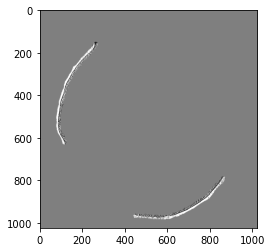

In [115]:
plt.imshow(a.numpy()*b.numpy(),cmap='gray')

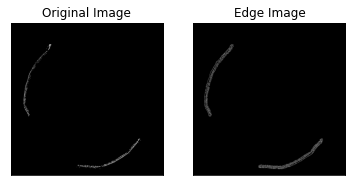

In [128]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np

img_or=a.numpy()*b.numpy()
img=np.uint8(img_or)
edges = cv.Canny(img,0.3,0.7)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [122]:
(a.numpy()*b.numpy())

(1024, 1024)

In [121]:
b.numpy().shape

(1024, 1024)

In [132]:
contour  = [(i,i) for i in range(10)]

In [151]:
contour = []
for i in range(10,30):
    for j in range(10,30):
        contour.append((i,j))

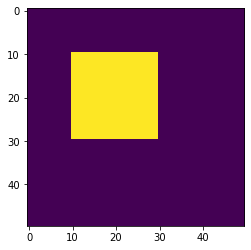

In [152]:
t = test_image(1,(50,50))
im = np.zeros((50,50))
for i,j in contour:
    im[i,j] = 1
plt.imshow(im)

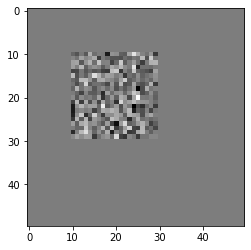

In [153]:
plt.imshow(t.numpy()*im,cmap='gray')

In [168]:
t_np = t.numpy()
t_np *= img

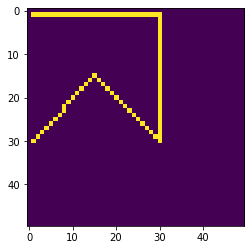

In [183]:
from skimage.draw import polygon, line
img = np.zeros((50, 50), dtype=np.uint8)
r = np.array([1, 1, 30,15,30])
c = np.array([1, 30, 30,15,1])
#rr, cc = polygon(r, c)
for i in range(0,4):
    rr, cc = line(r[i], c[i], r[i+1],c[i+1])
    img[rr, cc] = 1
img[rr, cc] = 1
img
plt.imshow(img)

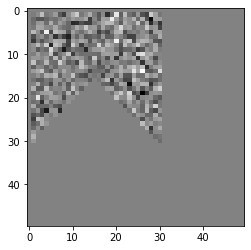

In [180]:
t = test_image(1,(50,50))
t_np = t.numpy()
t_np *= img
plt.imshow(t.numpy(),cmap='gray')

In [193]:
x = [[179.5, 416.5, 0.0, 0, 0], [179.5, 416.5, 0.0, 0, 0], [220.5, 306.5, 0.0, 0, 0], [339.5, 226.5, 0.0, 0, 0], [479.5, 219.5, 0.0, 0, 0]]

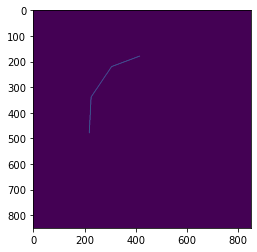

In [195]:
r = np.array([int(item[0]) for item in x])
c = np.array([int(item[1]) for item in x])
img = np.zeros((850, 850), dtype=np.uint8)
for i in range(len(r)-1):
    rr, cc = line(r[i], c[i], r[i+1],c[i+1])
    img[rr, cc] = 1
img[rr, cc] = 1
img
plt.imshow(img)

In [197]:
y = [[187.49999999999986, 272.0454545454543, 0, 0.0], [332.0454545454543, 269.3181818181816, 0, 0.0], [325.6818181818179, 140.2272727272726, 0, 0.0], [264.772727272727, 190.22727272727255, 0, 0.0], [206.59090909090892, 146.59090909090895, 0, 0.0]]

In [224]:
y = [[100,100],[100,300],[300,600],[600,100],[100,100]]
r = np.array([int(item[0]) for item in y])
c = np.array([int(item[1]) for item in y])
img = np.zeros((1024, 1024), dtype=np.uint8)
for i in range(len(r)-1):
    try:
        rr, cc, val = weighted_line(r[i], c[i], r[i+1],c[i+1], 10)
        img[rr, cc] = 2
    except:
        continue
#rr,cc = polygon(r,c)
img[rr, cc] = 1
img
plt.imshow(img, cmap = 'gray')

IndexError: list index out of range

In [217]:
def trapez(y,y0,w):
    return np.clip(np.minimum(y+1+w/2-y0, -y+1+w/2+y0),0,1)

def weighted_line(r0, c0, r1, c1, w, rmin=0, rmax=np.inf):
    # The algorithm below works fine if c1 >= c0 and c1-c0 >= abs(r1-r0).
    # If either of these cases are violated, do some switches.
    if c0 == c1 and r0 == r1:
        return 0,0,0
    if abs(c1-c0) < abs(r1-r0):
        # Switch x and y, and switch again when returning.
        xx, yy, val = weighted_line(c0, r0, c1, r1, w, rmin=rmin, rmax=rmax)
        return (yy, xx, val)

    # At this point we know that the distance in columns (x) is greater
    # than that in rows (y). Possibly one more switch if c0 > c1.
    if c0 > c1:
        return weighted_line(r1, c1, r0, c0, w, rmin=rmin, rmax=rmax)


    # The following is now always < 1 in abs
    slope = (r1-r0) / (c1-c0)

    # Adjust weight by the slope
    w *= np.sqrt(1+np.abs(slope)) / 2

    # We write y as a function of x, because the slope is always <= 1
    # (in absolute value)
    x = np.arange(c0, c1+1, dtype=float)
    y = x * slope + (c1*r0-c0*r1) / (c1-c0)

    # Now instead of 2 values for y, we have 2*np.ceil(w/2).
    # All values are 1 except the upmost and bottommost.
    thickness = np.ceil(w/2)
    yy = (np.floor(y).reshape(-1,1) + np.arange(-thickness-1,thickness+2).reshape(1,-1))
    xx = np.repeat(x, yy.shape[1])
    vals = trapez(yy, y.reshape(-1,1), w).flatten()

    yy = yy.flatten()

    # Exclude useless parts and those outside of the interval
    # to avoid parts outside of the picture
    mask = np.logical_and.reduce((yy >= rmin, yy < rmax, vals > 0))

    return (yy[mask].astype(int), xx[mask].astype(int), vals[mask])

In [206]:
a = [1,2,3,4,5]

In [208]:
a[1:-1]

[2, 3, 4]

In [225]:
i = 1000

In [ ]:
for i in range(100000000000000):   
    if (str(i)[-1]+str(i)[0:-1]) == 4*i:
        print(i)